Autor: Anja Delić

Prvi deo zadatka - Tabelarna obrada
- Filtiranje po datumu
- Uklanjanje nerelevantnih kolona

Drugi deo zadatka - Tekstualna obrada
- Lowercase
- Uklanjanje interpukcije
- Uklanjanje brojeva
- Uklanjanje STOP WORDS
- STEMMING
- N-GRAMS?
    

In [2]:
# Potrebne biblioteke
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datetime import datetime
import spacy
import multiprocessing 
from multiprocessing import Pool
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor
import time
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Preuzmi potrebne resurse
try:
    nltk.download('punkt_tab', quiet=True)
    nltk.download('stopwords', quiet=True)
except Exception as e:
    raise Exception("Greška pri preuzimanju NLTK resursa. Pokrenite: nltk.download('punkt_tab') i nltk.download('stopwords')")

# Učitaj spaCy model za hrvatski/srpski jezik
try:
    nlp = spacy.load('hr_core_news_sm')  # Hrvatski model radi i za srpski
    print("Koristim spaCy za lematizaciju.")
except OSError:
    raise Exception("spaCy model 'hr_core_news_sm' nije pronađen. Instalirajte ga sa: python -m spacy download hr_core_news_sm")


Koristim spaCy za lematizaciju.


In [4]:
# Ručna lista srpskih stop reči
stop_words = set([
    'je', 'i', 'u', 'na', 'sa', 'za', 'od', 'do', 'po', 'kao', 'ali', 'ili', 'a', 'što', 
    'koji', 'koja', 'koje', 'biti', 'ovaj', 'taj', 'sve', 'sam', 'si', 'jesam', 'su', 
    'se', 'da', 'ne', 'ni', 'te', 'ga', 'mu', 'joj', 'njemu', 'njen', 'njegov', 'njih', 
    'kroz', 'iz', 'pre', 'posle', 'kod', 'uz', 'bez', 'nad', 'pod', 'među', 'samo', 
    'već', 'još', 'tako', 'ovde', 'onde', 'tamo', 'svaki', 'svi', 'sva', 'svaka', 
    'nekoliko', 'mnogo', 'malo', 'dosta', 'kada', 'gde', 'kako', 'zašto', 'često', 
    'uvek', 'nikad', 'ponekad', 'odmah', 'sada', 'onda', 'juče', 'danas', 'sutra','nego', 'ako'
])

In [5]:
input_file = 'scraped_articles_pescanik_25_3_2025_for_exam.csv'
output_file = 'processed_articles_pescanik.csv'

In [6]:
# VERZIJA 1

# Dodatna ručna normalizacija sufiksa (ručni stemmer)
def custom_stem_suffixes(token):
    suffixes = set([
        'ski', 'ški', 'čki', 'ov', 'ev', 'in', 'ina', 'ine', 'ici', 'ić', 'ova', 'evi', 'ovi',
        'ima', 'ama', 'anje', 'enje', 'asti', 'isti', 'osti', 'nija', 'nije', 'niji'
    ])
    for suf in suffixes:
        if token.endswith(suf) and len(token) > len(suf) + 2:
            return token[:-len(suf)]
    return token

# Funkcija za tekstualnu obradu
def text_preprocessing(text, use_ngrams=False):
    if pd.isna(text) or not text.strip():  # Provera za NaN ili prazan string
        return ""
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Uklanjanje interpunkcije
    text = re.sub(r'[^\w\s]', '', text)
    
    # 3. Uklanjanje brojeva
    text = re.sub(r'\d+', '', text)
    
    # 4. Tokenizacija
    tokens = word_tokenize(text)
    
    # 5. Uklanjanje stop reči i kratkih reči
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    # 6. Lematizacija + ručna normalizacija sufiksa + lowercase lematizovanih tokena
    doc = nlp(' '.join(tokens))
    tokens = [custom_stem_suffixes(token.lemma_.lower()) for token in doc]
    
    # 7. Generisanje N-grama (opciono, samo bigrami)
    if use_ngrams:
        bigrams = ['_'.join(gram) for gram in ngrams(tokens, 2)]
        tokens = tokens + bigrams
    
    # 8. Vrati prečišćeni tekst
    return ' '.join(tokens)

# Glavna funkcija za predprocesiranje podataka
def preprocess_articles(input_csv, output_csv, use_ngrams=False):
    df = pd.read_csv(input_csv)
    print("Inicijalni broj redova:", len(df))

    # Konverzija datuma
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')

    # Filtriranje po datumu
    start_date = pd.Timestamp('2024-11-01')
    end_date = pd.Timestamp('2025-03-08')
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    print("Broj redova nakon filtriranja datuma:", len(df))
    print("Najraniji datum:", df['Date'].min())
    print("Najkasniji datum:", df['Date'].max())

    # Ukloni prazne tekstove
    df = df.dropna(subset=['Full Text'])  
    df = df[df['Full Text'].str.strip() != '']  
    print("Broj redova nakon uklanjanja praznih 'Full Text':", len(df))

    # Ukloni duplikate
    df = df.drop_duplicates(subset=['Full Text'])
    print("Broj redova nakon uklanjanja duplikata:", len(df))

    # Kombinuj Title i Full Text
    df['combined_text'] = df['Title'] + ' ' + df['Full Text']
    df = df[['combined_text']]

    # Predprocesiranje teksta
    df['processed_text'] = df['combined_text'].apply(
        lambda x: text_preprocessing(x, use_ngrams=use_ngrams)
    )
    
    # Ukloni redove sa praznim procesiranim tekstom
    df = df[df['processed_text'].str.strip() != '']
    print("Broj redova nakon predprocesiranja:", len(df))

    # Sačuvaj rezultat
    output_df = df[['processed_text']]
    output_df.to_csv(output_csv, index=False,header=False)
    print(f"Predprocesirani podaci sačuvani u {output_csv}")

In [6]:
start_time = time.time()
preprocess_articles(input_file, output_file)
end_time = time.time()

total_time = end_time - start_time
print(f"\nTotal execution time: {total_time:.2f} seconds")

final_count = len(pd.read_csv(output_file))
if final_count > 0:
    print(f"Processing speed: {final_count/total_time:.2f} articles/second")
    print(f"Average time per article: {total_time/final_count:.4f} seconds")

Inicijalni broj redova: 1030
Broj redova nakon filtriranja datuma: 454
Najraniji datum: 2024-11-01 00:00:00
Najkasniji datum: 2025-03-08 00:00:00
Broj redova nakon uklanjanja praznih 'Full Text': 449
Broj redova nakon uklanjanja duplikata: 443
Broj redova nakon predprocesiranja: 433
Predprocesirani podaci sačuvani u processed_articles_pescanik.csv

Total execution time: 55.41 seconds
Processing speed: 7.80 articles/second
Average time per article: 0.1283 seconds


In [ ]:
# VERZIJA 2
# Implementacije za obradu teksta sa optimizovanim performansama

# Unapred kompajlirani regex obrasci za uklanjanje interpunkcije i brojeva
PUNCT_PATTERN = re.compile(r'[^\w\s]')  # Uklanja sve znakove koji nisu slova ili razmaci
DIGIT_PATTERN = re.compile(r'\d+')      # Uklanja sve nizove brojeva

# Optimizovano uklanjanje sufiksa sa keširanjem za brže izvršavanje
SUFFIXES = {
    'ski', 'ški', 'čki', 'ov', 'ev', 'in', 'ina', 'ine', 'ici', 'ić', 'ova', 'evi', 'ovi',
    'ima', 'ama', 'anje', 'enje', 'asti', 'isti', 'osti', 'nija', 'nije', 'niji'
}  # Lista uobičajenih sufiksa u srpskom jeziku

@lru_cache(maxsize=10000)
def custom_stem_suffixes(token):
    # Funkcija za uklanjanje sufiksa iz tokena sa keširanjem
    # Ako token završava na definisani sufiks i dovoljno je dugačak, uklanja sufiks
    for suf in SUFFIXES:
        if token.endswith(suf) and len(token) > len(suf) + 2:
            return token[:-len(suf)]  # Vraća token bez sufiksa
    return token  # Ako nema sufiksa, vraća originalni token

# Obrada teksta u paketima koristeći spaCy za efikasnu lematizaciju
def process_batch(texts, nlp):
    docs = list(nlp.pipe(texts, batch_size=50))  # Obrada u grupama od 50 tekstova
    return docs

# Funkcija za pretprocesiranje pojedinačnog teksta
def text_preprocessing(text, use_ngrams=False):
    if pd.isna(text) or not text.strip():
        return ""  # Vraća prazan string ako je tekst prazan ili NaN
    
    # Kombinovana primena regex operacija za uklanjanje interpunkcije i brojeva
    text = DIGIT_PATTERN.sub('', PUNCT_PATTERN.sub('', text.lower()))  # Konvertuje u mala slova
    
    # Tokenizacija i filtriranje: uklanja stop reči i kratke tokene
    tokens = [token for token in word_tokenize(text) 
              if token not in stop_words and len(token) > 2]
    
    if not tokens:
        return ""  # Vraća prazan string ako nema validnih tokena
    
    # Lematizacija koristeći spaCy, ali koristi process_batch ako je lista tokena duga
    #cleaned_text = ' '.join(tokens)
    #  Pozivamo process_batch (koja koristi nlp.pipe) za ubrzanje
    #doc = process_batch([cleaned_text], nlp)[0]

    # Lematizacija tokena koristeći spaCy, isključujući parsiranje i NER za brzinu
    doc = nlp(' '.join(tokens), disable=['parser', 'ner'])
    tokens = [custom_stem_suffixes(token.lemma_.lower()) for token in doc]  # Lematizacija i stemming
    
    if use_ngrams:
        # Generisanje bigrama ako je opcija uključena
        bigrams = ['_'.join(gram) for gram in ngrams(tokens, 2)]
        tokens.extend(bigrams)  # Dodavanje bigrama na listu tokena
    
    return ' '.join(tokens)  # Vraća obrađeni tekst kao string

# Funkcija za pretprocesiranje članaka iz CSV fajla
def preprocess_articles(input_csv, output_csv, use_ngrams=False):
    # Učitavanje CSV fajla sa optimizovanim tipovima podataka
    df = pd.read_csv(input_csv, dtype={'Full Text': 'str', 'Title': 'str'})
    print("Početni broj redova:", len(df))  # Ispis početnog broja redova

    # Konverzija datuma i filtriranje po opsegu datuma
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
    date_mask = (df['Date'] >= '2024-11-01') & (df['Date'] <= '2025-03-08')
    df = df[date_mask].copy()  # Filtriranje i kopiranje podataka
    print("Broj redova nakon filtriranja datuma:", len(df))  # Ispis broja redova nakon filtriranja

    # Čišćenje teksta: uklanjanje praznih i duplikata
    df['Full Text'] = df['Full Text'].str.strip()
    df = df[df['Full Text'].astype(bool)].dropna(subset=['Full Text'])
    df = df.drop_duplicates(subset=['Full Text'])
    print("Broj redova nakon čišćenja teksta:", len(df))  # Ispis broja redova nakon čišćenja

    # Kombinovanje naslova i punog teksta u jednu kolonu
    df['combined_text'] = df['Title'].str.cat(df['Full Text'], sep=' ')
    
    # Obrada tekstova u paketima za efikasnost
    texts = df['combined_text'].tolist()
    processed_texts = [text_preprocessing(text, use_ngrams) for text in texts]
    
    df['processed_text'] = processed_texts  # Dodavanje obrađenog teksta u DataFrame
    df = df[df['processed_text'].str.strip().astype(bool)]  # Uklanjanje praznih tekstova
    print("Konačni broj redova:", len(df))  # Ispis konačnog broja redova

    # Čuvanje obrađenih podataka u CSV fajl
    df[['processed_text']].to_csv(output_csv, index=False, header=False)
    print(f"Obradjeni podaci sačuvani u {output_csv}")  # Potvrda čuvanja fajla

In [10]:

start_time2 = time.time()
preprocess_articles(input_file, output_file)
end_time2 = time.time()

total_time2 = end_time2 - start_time2
print(f"\nTotal execution time: {total_time2:.2f} seconds")

final_count = len(pd.read_csv(output_file))
if final_count > 0:
    print(f"Processing speed: {final_count/total_time2:.2f} articles/second")
    print(f"Average time per article: {total_time2/final_count:.4f} seconds")


Početni broj redova: 1030
Broj redova nakon filtriranja datuma: 454
Broj redova nakon čišćenja teksta: 443
Konačni broj redova: 433
Obradjeni podaci sačuvani u processed_articles_pescanik.csv

Total execution time: 28.98 seconds
Processing speed: 14.91 articles/second
Average time per article: 0.0671 seconds


In [ ]:
# VERZIJA 3
# Implementacije za obradu teksta sa dodatnim optimizacijama i paralelnim procesiranjem

# Unapred kompajlirani regex obrasci za uklanjanje interpunkcije i brojeva
PUNCT_PATTERN = re.compile(r'[^\w\s]')  # Uklanja sve znakove koji nisu slova ili razmaci
DIGIT_PATTERN = re.compile(r'\d+')      # Uklanja sve nizove brojeva

# Lista sufiksa pretvorena u frozenset za brži pristup
SUFFIXES = frozenset({
    'ski', 'ški', 'čki', 'ov', 'ev', 'in', 'ina', 'ine', 'ici', 'ić', 'ova', 'evi', 'ovi',
    'ima', 'ama', 'anje', 'enje', 'asti', 'isti', 'osti', 'nija', 'nije', 'niji'
})  # Frozenset za efikasnije pretrage sufiksa

# Učitavanje spaCy modela sa minimalnim komponentama za bržu obradu
try:
    nlp = spacy.load('hr_core_news_sm', disable=['parser', 'ner', 'tagger'])  # Isključivanje nepotrebnih komponenti
    nlp.max_length = 2000000  # Povećanje maksimalne dužine teksta za duge dokumente
except OSError:
    raise Exception("spaCy model 'hr_core_news_sm' nije pronađen. Instalirajte ga sa: python -m spacy download hr_core_news_sm")

@lru_cache(maxsize=50000)
def custom_stem_suffixes(token):
    # Funkcija za uklanjanje sufiksa iz tokena sa keširanjem i povećanim kapacitetom
    for suf in SUFFIXES:
        if token.endswith(suf) and len(token) > len(suf) + 2:
            return token[:-len(suf)]  # Vraća token bez sufiksa
    return token  # Ako nema sufiksa, vraća originalni token

# Funkcija za pretprocesiranje pojedinačnog teksta
def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str) or not text.strip():
        return ""  # Vraća prazan string ako je tekst prazan, nije string ili NaN
    
    # Kombinovana primena regex operacija za uklanjanje interpunkcije i brojeva
    text = DIGIT_PATTERN.sub('', PUNCT_PATTERN.sub('', text.lower()))  # Konvertuje u mala slova
    tokens = [token for token in word_tokenize(text) 
              if token not in stop_words and len(token) > 2]  # Filtriranje stop reči i kratkih tokena
    
    if not tokens:
        return ""  # Vraća prazan string ako nema validnih tokena
    
    # Obrada tokena koristeći spaCy za lematizaciju
    doc = nlp(' '.join(tokens))
    return ' '.join(custom_stem_suffixes(token.lemma_.lower()) for token in doc)  # Lematizacija i stemming

# Obrada tekstova u paketima koristeći paralelizaciju
def process_batch(texts):
    """Obrada paketa tekstova paralelno"""
    with ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
        return list(executor.map(preprocess_text, texts))  # Paralelna obrada tekstova

# Funkcija za pretprocesiranje članaka iz CSV fajla
def preprocess_articles(input_csv, output_csv):
    # Učitavanje CSV fajla sa optimizovanim tipovima podataka i parsiranjem datuma
    df = pd.read_csv(
        input_csv,
        dtype={'Full Text': 'string', 'Title': 'string'},
        parse_dates=['Date'],
        dayfirst=True
    )
    print(f"Početni broj redova: {len(df):,}")  # Ispis početnog broja redova
    
    # Filtriranje po opsegu datuma
    date_mask = (df['Date'] >= '2024-11-01') & (df['Date'] <= '2025-03-08')
    df = df[date_mask].copy()
    print(f"Nakon filtriranja datuma: {len(df):,}")  # Ispis broja redova nakon filtriranja
    
    # Čišćenje teksta: uklanjanje praznih i NaN vrednosti, uklanjanje duplikata
    df['Full Text'] = df['Full Text'].str.strip()
    df = df[~df['Full Text'].isna() & (df['Full Text'] != '')]
    df = df.drop_duplicates(subset=['Full Text'])
    print(f"Nakon čišćenja teksta: {len(df):,}")  # Ispis broja redova nakon čišćenja
    
    # Kombinovanje naslova i punog teksta
    df['combined_text'] = df['Title'] + ' ' + df['Full Text']
    
    # Obrada u paralelnim paketima
    batch_size = 1000  # Veličina paketa za obradu
    batches = [df['combined_text'][i:i + batch_size] 
               for i in range(0, len(df), batch_size)]  # Podela na pakete
    
    processed_texts = []
    for batch in batches:
        processed_texts.extend(process_batch(batch.tolist()))  # Obrada svakog paketa
    
    df['processed_text'] = processed_texts
    df = df[df['processed_text'].str.strip() != '']  # Uklanjanje praznih tekstova
    print(f"Konačni broj redova: {len(df):,}")  # Ispis konačnog broja redova
    
    # Čuvanje obrađenih podataka u CSV fajl sa UTF-8-SIG kodiranjem
    df[['processed_text']].to_csv(
        output_csv, 
        index=False,
        header=False,
        encoding='utf-8-sig'
    )
    print(f"Sačuvano u {output_csv}")  # Potvrda čuvanja fajla

In [10]:
start_time3 = time.time()
preprocess_articles(input_file, output_file)
end_time3 = time.time()

total_time3 = end_time3 - start_time3
print(f"\nTotal execution time: {total_time3:.2f} seconds")

final_count = len(pd.read_csv(output_file))
if final_count > 0:
    print(f"Processing speed: {final_count/total_time3:.2f} articles/second")
    print(f"Average time per article: {total_time3/final_count:.4f} seconds")

Početni broj redova: 1,030
Nakon filtriranja datuma: 454
Nakon čišćenja teksta: 443
Konačni broj redova: 433
Sačuvano u processed_articles_pescanik.csv

Total execution time: 10.74 seconds
Processing speed: 40.21 articles/second
Average time per article: 0.0249 seconds


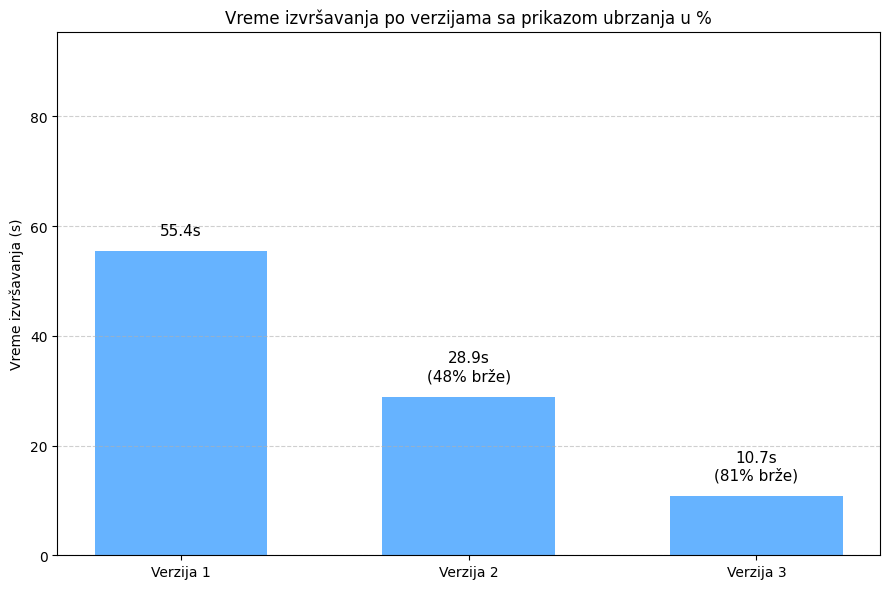

In [14]:
# Vremena iz različitih verzija
execution_times = [total_time, total_time2, total_time3]
labels = ['Verzija 1', 'Verzija 2', 'Verzija 3']

# Definisanje baseline-a kao vremena verzije 1
baseline = execution_times[0]

# Procentualna ubrzanja u odnosu na Verziju 1
speedup_percent = [0] + [(baseline - t) / baseline * 100 for t in execution_times[1:]]

# Crtanje stubova
x = np.arange(len(labels))
width = 0.6

plt.figure(figsize=(9, 6))
bars = plt.bar(x, execution_times, width=width, color='#66B3FF')

# Dodavanje oznaka: vreme i ubrzanje
for i, bar in enumerate(bars):
    height = bar.get_height()
    time_label = f'{height:.1f}s'
    if i == 0:
        plt.text(bar.get_x() + width/2, height + 3, time_label, ha='center', fontsize=11)
    else:
        speed_label = f'({speedup_percent[i]:.0f}% brže)'
        full_label = f'{time_label}\n{speed_label}'
        plt.text(bar.get_x() + width/2, height + 3, full_label, ha='center', fontsize=11)

# Podešavanje grafa
plt.xticks(x, labels)
plt.ylabel('Vreme izvršavanja (s)')
plt.title('Vreme izvršavanja po verzijama sa prikazom ubrzanja u %')
plt.ylim(0, max(execution_times) + 40)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()